# CIFAR10 Classification

### HW2 @ DL Course, Dr. Soleymani

*Full Name:* Esra Kashaninia

*SID:* 402210676

In this part of the assignment we want to do an image classification task using PyTorch on CIFAR10 dataset.

## Import Libraries

Import needed libraries

In [1]:
import torch
import torchvision
from torchvision import transforms

## Device

Set device to work with (GPU or CPU)

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Transforms & Dataset & Dataloader

Here, you should download and load the dataset with the desire transforms. After that, you should split train dataset to train and validation sets. Finally, define the dataloaders for `train`, `validation` and `test`

In [3]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [4]:
mean=(0.5, 0.5, 0.5)
std=(0.20, 0.20, 0.20)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

In [5]:
# inverse the normilize transform to restore the original data
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        # TODO
        tensor = tensor.copy()
        for i, (mu, sigma) in enumerate(zip(self.mean, self.std)):
            tensor[i] = tensor[i] * sigma + mu
        tensor = tensor.transpose(1, 2, 0)
        return tensor

norminv = UnNormalize(mean=(0.5, 0.5, 0.5), std=(0.20, 0.20, 0.20))

In [6]:
initial_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)

100%|██████████| 170498071/170498071 [00:01<00:00, 96525694.27it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data


In [7]:
trainset, valset = torch.utils.data.random_split(initial_trainset, [int(0.75 * len(initial_trainset)), int(0.25 * len(initial_trainset))])
# trainset, dummy = torch.utils.data.random_split(trainset, [int(0.5 * len(trainset)), int(0.5 * len(trainset))])

In [8]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=512)

In [9]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=512)

Files already downloaded and verified


## Visualization

Visualize 5 random images from each class in different columns

- **Hint**:  You can use `plt.subplots` for visualization

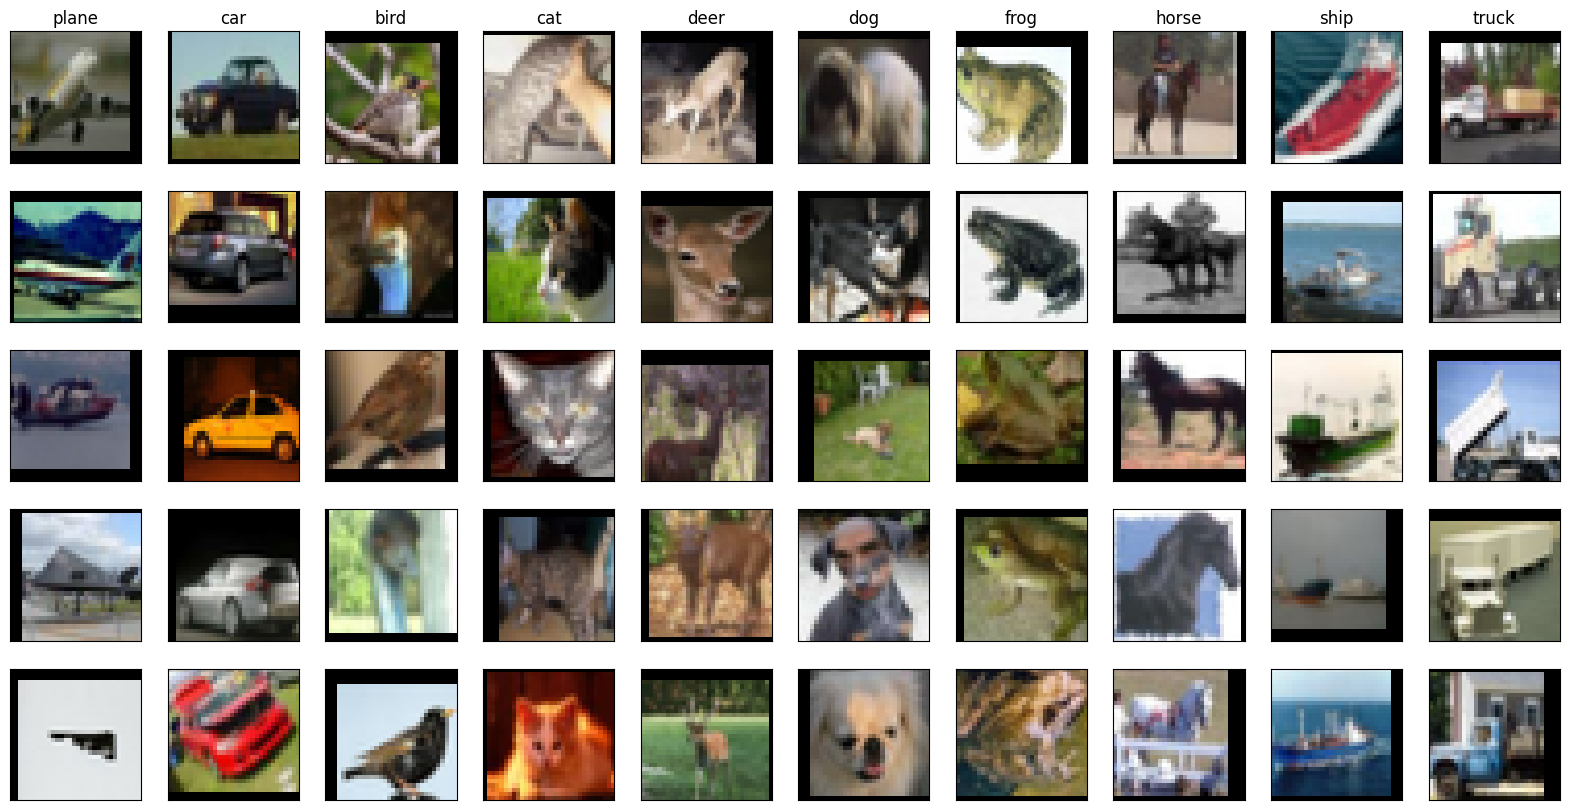

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

numofsamples = 5
numofclasses = len(classes)
class_dict = {i:e for i, e in enumerate(classes)}

count_dict = defaultdict(int)
images = [[] for i in range(numofclasses)]
for imgs, labels in trainloader:
  for img, label in zip(imgs, labels):
    images[label].append(img)
    count_dict[label] += 1
  if min(list(count_dict.values())) >= numofsamples:
    break

f, axarr = plt.subplots(numofsamples, numofclasses, figsize=(20, 10))
for i in range(numofclasses):
    axarr[0, i].set_title(classes[i])
    for j in range(numofsamples):
        axarr[j, i].imshow(norminv(images[i][j].numpy()))
        axarr[j, i].get_xaxis().set_visible(False)
        axarr[j, i].get_yaxis().set_visible(False)
plt.show()

## Model

Define your ResNet model here from scratch (You are not allowed to use the existing models in pytorch)

Our suggestion is to implement ResNet18

In [11]:
from torch import nn
import torch.nn.functional as F

class ResNetBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, stride=1):
        super(ResNetBlock, self).__init__()
        self.block = nn.Sequential(
        nn.Conv2d(
          in_channels=in_channels,
          out_channels=out_channels,
          kernel_size= kernel_size,
          padding = padding,
          stride=stride
        ),
        nn.BatchNorm2d(out_channels),
        )

    def forward(self, x):
        return self.block(x)

class ResNet18(torch.nn.Module):
    def __init__(self):
        super(ResNet18, self).__init__()
        self.layer1 = nn.Sequential(
            ResNetBlock(
                in_channels = 3, # Because RGB
                out_channels = 64
            ),
            nn.ReLU()
        )
        self.layer2 = nn.Sequential(
            ResNetBlock(
                in_channels = 64,
                out_channels = 64
            ),
            nn.ReLU(),
            ResNetBlock(
                in_channels = 64,
                out_channels = 64
            )
        )
        self.layer3 = nn.Sequential(
            ResNetBlock(
                in_channels = 64,
                out_channels = 64
            ),
            nn.ReLU(),
            ResNetBlock(
                in_channels = 64,
                out_channels = 64
            )
        )
        self.layer4 = nn.Sequential(
            ResNetBlock(
                in_channels = 64,
                out_channels = 128,
                stride=2
            ),
            nn.ReLU(),
            ResNetBlock(
                in_channels = 128,
                out_channels = 128
            )
        )
        self.layer4residual = nn.Sequential(
            ResNetBlock(
                in_channels = 64,
                out_channels = 128, # Because ResNet
                kernel_size = 1,    # 1*1 filter
                padding = 0,    # 1*1 filter doesn't need padding
                stride = 2
            )
        )
        self.layer5 = nn.Sequential(
            ResNetBlock(
                in_channels = 128,
                out_channels = 128
            ),
            nn.ReLU(),
            ResNetBlock(
                in_channels = 128,
                out_channels = 128
            )
        )
        self.layer5 = nn.Sequential(
            ResNetBlock(
                in_channels = 128,
                out_channels = 128
            ),
            nn.ReLU(),
            ResNetBlock(
                in_channels = 128,
                out_channels = 128
            )
        )
        self.layer6 = nn.Sequential(
            ResNetBlock(
                in_channels = 128,
                out_channels = 256,
                stride = 2
            ),
            nn.ReLU(),
            ResNetBlock(
                in_channels = 256,
                out_channels = 256
            )
        )
        self.layer6residual = nn.Sequential(
            ResNetBlock(
                in_channels = 128,  # Because Resnet
                out_channels = 256,
                kernel_size = 1,    # 1*1 filter
                padding = 0,    # 1*1 filter doesn't need padding
                stride = 2
            )
        )
        self.layer7 = nn.Sequential(
            ResNetBlock(
                in_channels = 256,
                out_channels = 256
            ),
            nn.ReLU(),
            ResNetBlock(
                in_channels = 256,
                out_channels = 256
            )
        )
        self.layer8 = nn.Sequential(
            ResNetBlock(
                in_channels = 256,
                out_channels = 512,
                stride = 2
            ),
            nn.ReLU(),
            ResNetBlock(
                in_channels = 512,
                out_channels = 512
            )
        )
        self.layer8residual = nn.Sequential(
            ResNetBlock(
                in_channels = 256,  # Because Resnet
                out_channels = 512,
                kernel_size = 1,    # 1*1 filter
                padding = 0,    # 1*1 filter doesn't need padding
                stride = 2
            )
        )
        self.layer9 = nn.Sequential(
            ResNetBlock(
                in_channels = 512,
                out_channels = 512
            ),
            nn.ReLU(),
            ResNetBlock(
                in_channels = 512,
                out_channels = 512
            )
        )
        self.layer10 = nn.Linear(512, numofclasses)

    def forward(self, x):
        x = self.layer1(x)
        x = F.relu(self.layer2(x) + x)
        x = F.relu(self.layer3(x) + x)
        x = F.relu(self.layer4(x) + self.layer4residual(x))
        x = F.relu(self.layer5(x) + x)
        x = F.relu(self.layer6(x) + self.layer6residual(x))
        x = F.relu(self.layer7(x) + x)
        x = F.relu(self.layer8(x) + self.layer8residual(x))
        x = F.relu(self.layer9(x) + x)
        x = F.avg_pool2d(x, 4)
        x = x.view(x.size(0), -1)
        x = self.layer10(x)
        return x

## Train

### Model instantiation

Create an instance of your model and move it to `device`

In [12]:
net = ResNet18().to(device)

### Criterion & Optimizater

Define `criterion` and `optimizer` (Or `scheduler`)

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.75)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

### Train loop

Train your model

Tasks:
- [ ] Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Train accuracy
  - Validation loss
  - Validation accuracy
- [ ] save train/validation loss and accuracy (of each epoch) in an array for later usage

In [14]:
import tqdm
from time import time

import copy

In [15]:
def train_epoch(net: torch.nn.Module, criterion: torch.nn.Module, optimizer: torch.optim.Optimizer,scheduler: torch.optim.lr_scheduler ,dataloader: torch.utils.data.DataLoader):
    global train_accs, train_losses
    # checker = 0
    train_loss = 0
    train_accuracy = 0
    net.train()
    total_len = len(dataloader.dataset)
    for data in dataloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # checker += 1
        # if checker % 20 == 0:
        #     print(f"Checker: {checker} / {len(dataloader.dataset)}")

        predicted = torch.max(outputs, 1)[1]
        train_loss += loss.item() * len(inputs)
        train_accuracy += ((predicted == labels).flatten().sum().item())

    train_accuracy /= total_len
    train_loss /= total_len
    train_accs.append(train_accuracy)
    train_losses.append(train_loss)
    print("Train Loss:", train_loss,  "Train Accuracy", train_accuracy)
    scheduler.step()

def eval_epoch(net: torch.nn.Module, criterion: torch.nn.Module, dataloader: torch.utils.data.DataLoader, test_mode: bool = False):
    global valid_accs, valid_losses
    valid_accuracy = 0
    valid_loss = 0
    net.eval()

    total_len = len(dataloader.dataset)
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            valid_loss += criterion(outputs, labels).item() * len(inputs)

            predicted = torch.max(outputs, 1)[1]
            valid_accuracy += (predicted == labels).flatten().sum().item()

    valid_accuracy /= total_len
    valid_loss /= total_len
    valid_accs.append(valid_accuracy)
    valid_losses.append(valid_loss)

    dataset_str = "Test" if test_mode else "Validation"
    print(dataset_str + " " + "Loss: " , valid_loss, dataset_str + " " + "Accuracy: ", valid_accuracy)


In [16]:
epochs = 25 # no time!

train_accs = []
valid_accs = []
train_losses = []
valid_losses = []

for e in range(epochs):
    print("Epoch", str(e + 1))
    train_epoch(net, criterion, optimizer, scheduler, trainloader)
    eval_epoch(net, criterion, valloader)
    print("-" * 200)

Epoch 1
Train Loss: 1.7209142249043783 Train Accuracy 0.35973333333333335
Validation Loss:  1.5320463229370118 Validation Accuracy:  0.4456
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch 2
Train Loss: 1.3187481550216675 Train Accuracy 0.5195466666666667
Validation Loss:  1.4446280349349976 Validation Accuracy:  0.48648
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch 3
Train Loss: 1.1169423361460369 Train Accuracy 0.5977866666666667
Validation Loss:  1.4274917528152467 Validation Accuracy:  0.5136
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Visualize Loss and Accuracy plot

Using the arrays that you have (from task 2 in the above section), visualize two plots: Accuracy plot (train and validation together) and Loss plot (train and validation together)

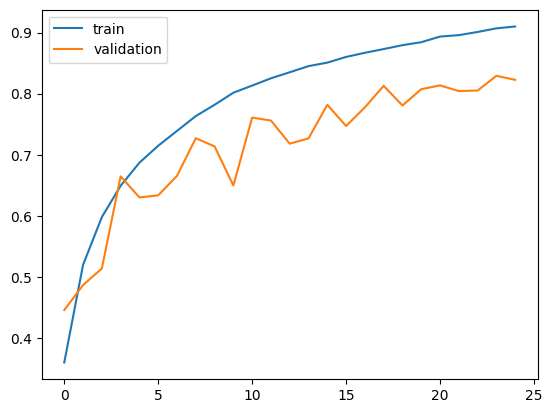

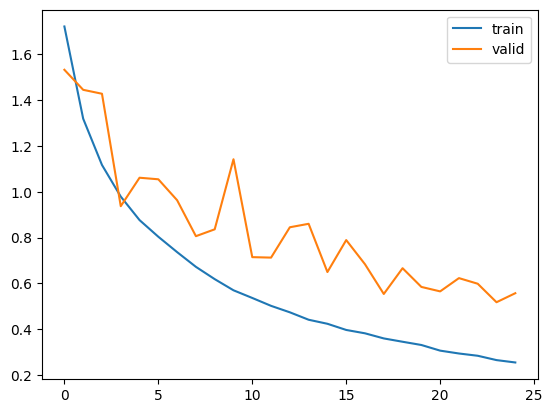

In [17]:
plt.plot(train_accs, label='train')
plt.plot(valid_accs, label='validation')
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='validation')
plt.legend()
plt.title("Loss")
plt.show()

## Evaluation

Test your trained model (using the Test Dataloader that you have). Our goal is to reach an accuracy above `80%`

In [18]:
eval_epoch(net, criterion, testloader, test_mode=True)

Test Loss:  0.5878250495910644 Test Accuracy:  0.8236


## Visualize incorrectly predicted samples from testset

Visualize *24* random images from testset that are incorrectly predicted by the model

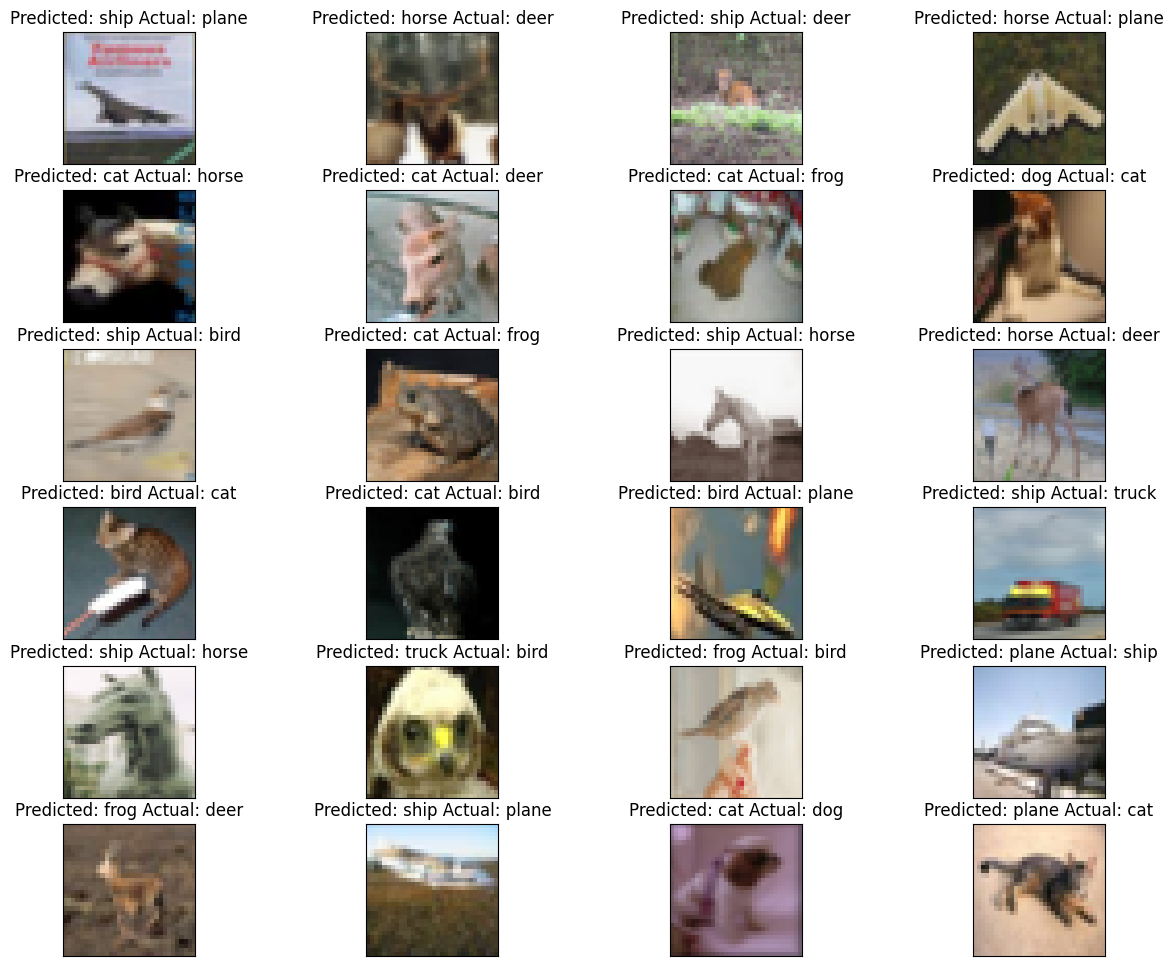

In [19]:
f, axarr = plt.subplots(6, 4, figsize=(15, 12))
i = 0
j = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        for img, ypred, ytest in zip(inputs, predicted, labels):
            if ypred != ytest:
                axarr[i, j].imshow(norminv(img.cpu().numpy()))
                axarr[i, j].set_title("Predicted: " + str(classes[ypred]) + " Actual: " + str(classes[ytest]))
                axarr[i, j].get_xaxis().set_visible(False)
                axarr[i, j].get_yaxis().set_visible(False)
                j += 1
                if j == 4:
                    j = 0
                    i += 1
                if i == 6:
                    break
        if i == 6:
            break
plt.show()

## Exploring the feature space

### Calculate the feature space for all training samples

You have trained and evaluated your model. Now, for each sample in the trainset, calculate it's "feature space" discussed in the model section. The result of this section should be a tensor of size `(50000, N)` saved in a variable (for later usage)

- **Hint 1:** define a tensor with dimension `(50000, N)` where *50000* is the size of the trainset and *N* is the dimension of the feature space

- **Hint 2:** Pay attension to the `shuffle` attribute of your train dataloader (If needed)

In [20]:
initial_loader = torch.utils.data.DataLoader(initial_trainset, batch_size=512, shuffle=False)

features = []
ytrue = []
ypred = []

with torch.no_grad():
    for data in initial_loader:
        X, Y = data[0].to(device), data[1].to(device)
        features += X
        ytrue += Y

        x = net.layer1(X)
        x = F.relu(net.layer2(x) + x)
        x = F.relu(net.layer3(x) + x)
        x = F.relu(net.layer4(x) + net.layer4residual(x))
        x = F.relu(net.layer5(x) + x)
        x = F.relu(net.layer6(x) + net.layer6residual(x))
        x = F.relu(net.layer7(x) + x)
        x = F.relu(net.layer8(x) + net.layer8residual(x))
        x = F.relu(net.layer9(x) + x)
        x = F.avg_pool2d(x, 4)
        x = x.view(x.size(0), -1)

        ypred += x


features = torch.stack(features)
ypred = torch.stack(ypred)
ytrue = torch.stack(ytrue)

print(features.size()) # Khodesh 50000 tast slice nemikhad

torch.Size([50000, 3, 32, 32])


### K Nearest Neighbor in feature space

You already have calculated the feature spaces for trainset ($S$) in the previous section

1. Get 5 random samples from testset which are correctly predicted by the model.
2. for each sample, calculate it's "feature space" ($X$)
3. for each sample, calculate it's *5* nearest neighbors in "feature space" in the trainset (by comparing $X$ to each row in $S$) and visualize them


**Hint:** For finding the nearest neighbors in the feature space you can use `torch.linalg.norm` and `torch.topk`

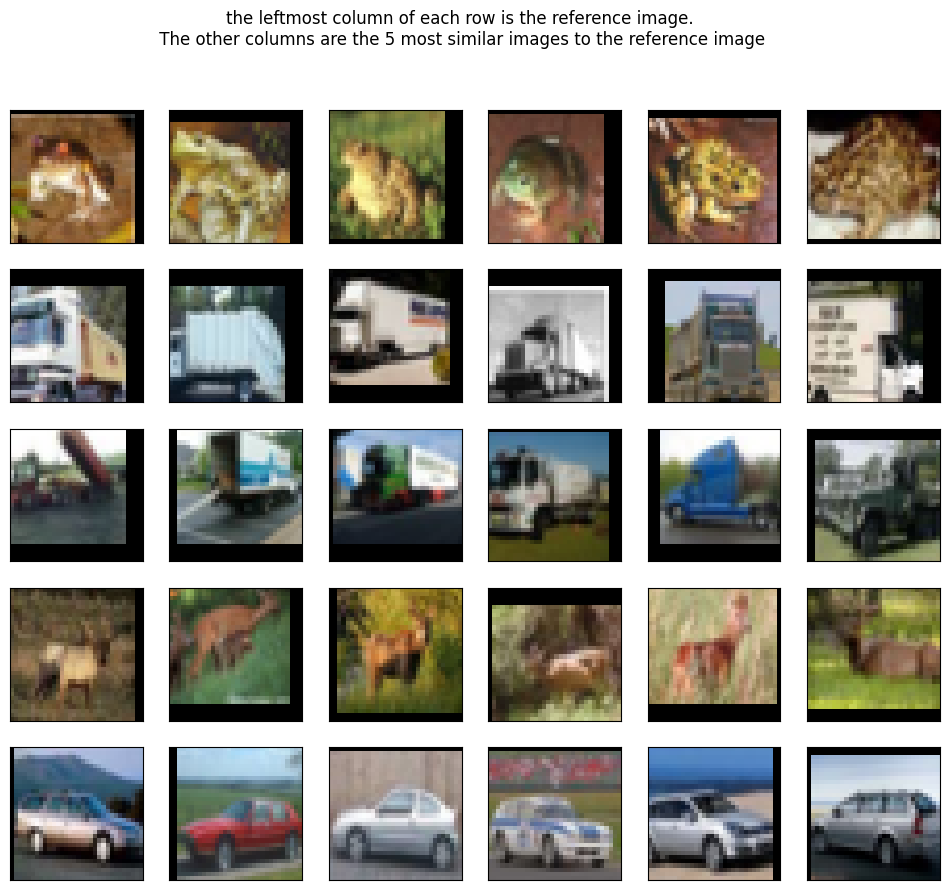

In [21]:
top_k = 5
f, axarr = plt.subplots(5, top_k + 1, figsize=(12, 10))
# plt.title("the leftmost column of each row is reference image. The others are the 5 most similar images")
f.suptitle("the leftmost column of each row is the reference image.\n The other columns are the 5 most similar images to the reference image", fontsize='large')
i = 0
with torch.no_grad():
    predicted = torch.max(net.layer10(ypred), 1)[1]
    for predict, label, inp, out in zip(predicted, ytrue, features, ypred):
        if predict == label:
            similar_imgs = features[torch.topk(torch.linalg.norm(ypred - out, dim=1), k=top_k + 1, largest=False)[1]]
            for j in range(len(similar_imgs)):
                img = norminv(similar_imgs[j].detach().cpu().numpy())
                axarr[i, j].imshow(img)
                axarr[i, j].get_xaxis().set_visible(False)
                axarr[i, j].get_yaxis().set_visible(False)
            i += 1
        if i == 5:
            break
plt.show()

### TSNE

1. Sample $M$ ($2000$ would be enought) random samples from the trainset feature space (calculated in the above sections)
2. Now you have a vector of size `(M, N)` where $N$ is the dimension of the feature space
3. Using TSNE reduce $N$ to $2$ (Now you have a vector of size `(M, 2)`)
4. Visualize the points in a 2D plane (Set color of each point based on it's class)

**Hint:** You can use `sklearn.manifold.TSNE`

**Hint:** Use `plt.scatter(x, y, c=labels)`


In [22]:
from sklearn.manifold import TSNE
import plotly.express as px

tx = ypred.detach().cpu().numpy()
ty = ytrue.detach().cpu().numpy()
# print(tx.shape)
# print(ty.shape)
idx = np.random.choice(np.arange(len(tx)), 2000, replace=False)
x_sample = tx[idx]
y_sample = ty[idx]

tsne = TSNE(n_components=2,perplexity=40, random_state=42)
X_train_tsne = tsne.fit_transform(x_sample)

fig = px.scatter(x=X_train_tsne[:, 0], y=X_train_tsne[:, 1], color=y_sample)

fig.show()

# CIFAR10 Colorization

In this part of the assignment, we want to do an image colorization task using PyTorch on CIFAR10 dataset. We want to train a model that colors  a black-and-white image.

## Import Libraries

Import needed libraries

In [38]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [39]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Custom Dataset

Define a custom dataset class by extensing `torch.utils.data.Dataset`

**Notice:** your dataset should output two things: black-and-white image and the RGB image

**Hint:** You don't have to reinvent the wheel. Your class should just be a wrapper for CIFAR10 dataset

In [40]:
class BlackAndWhiteCIFAR10(Dataset):
    """
    Define a custom dataset class by extending `torch.utils.data.Dataset`
    this class is a dataset for the CIFAR10 data in pytorch and it has the black and white image of the original CIFAR10 image as the data
    and the original RGB image as the target
    this class is just a wrapper for the torchvision.datasets.CIFAR10 class
    """

    def __init__(self, train=True, root='./data', download=True, transform=None):
        self.dset = torchvision.datasets.CIFAR10(train=train, root=root, download=download, transform=transform)
        self.graytrans = transforms.Grayscale()

    def __len__(self):
        return len(self.dset)

    def __getitem__(self, index):
        colored = self.dset[index][0]
        gray = self.graytrans(colored)
        return gray, colored

## Transforms & Dataset & Dataloader

**Notice:** Use your defined custom dataset class for defining the datasets

In [41]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [42]:
transform_train = transforms.ToTensor()

transform_test = transforms.ToTensor()

In [43]:
initial_trainset = BlackAndWhiteCIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)

Files already downloaded and verified


In [44]:
trainset, valset = torch.utils.data.random_split(initial_trainset,
                                                 [int(0.75 * len(initial_trainset)), int(0.25 * len(initial_trainset))])

In [45]:
trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=512)
valloader = torch.utils.data.DataLoader(valset, shuffle=False, batch_size=512)

## Dataset Visualization

Visualize your dataset (black-and-white image along with the RGB image) by sampling from your trainset

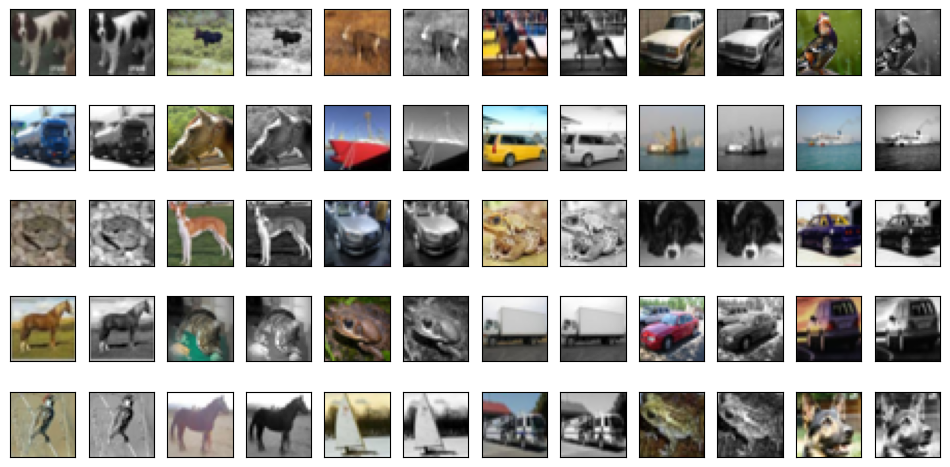

In [46]:
import matplotlib.pyplot as plt

rows, cols = 5, 6
f, axarr = plt.subplots(rows, cols * 2, figsize=(12, 6))

for i in range(rows):
  for j in range(cols):
    gray, colored = trainset[i * cols + j]
    axarr[i, 2 * j].imshow(colored.detach().cpu().numpy().transpose(1, 2, 0)) #, cmap='pink')
    axarr[i, 2 * j + 1].imshow(gray.detach().cpu().numpy()[0], cmap='gray')

    axarr[i, 2 * j].get_xaxis().set_visible(False)
    axarr[i, 2 * j].get_yaxis().set_visible(False)
    axarr[i, 2 * j + 1].get_xaxis().set_visible(False)
    axarr[i, 2 * j + 1].get_yaxis().set_visible(False)
plt.show()

## Model

Define your model here (Input: black-and-white image, Output: RGB image)

**Hint:** You can implement an autoencoder that does the colorization task for you. UNet could be a viable option

In [47]:
import torch.nn as nn
from torch.nn import functional as F


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, stride=1):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
        nn.Conv2d(in_channels = in_channels,
                  out_channels = out_channels,
                  kernel_size = kernel_size,
                  stride = stride,
                  padding = padding),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(inplace=True),
        nn.Conv2d(in_channels = out_channels, #stupid stupid bug
                  out_channels = out_channels,
                  kernel_size = kernel_size,
                  stride = stride,
                  padding = padding),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(inplace=True)
        )

    def forward(self, x):
        x = self.block(x)
        return x

class TransConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransConvBlock, self).__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = ConvBlock(in_channels, out_channels)

    def forward(self, x, skip_input):
        x = self.up(x)
        dy = skip_input.size()[2] - x.size()[2]
        dx = skip_input.size()[3] - x.size()[3]
        x = F.pad(x, (int(dx / 2), int((dx + 1) / 2), int(dy / 2), int((dy + 1) / 2)))
        x = torch.cat([skip_input, x], dim=1)
        x = self.conv(x)
        return x

class colorizationNet(nn.Module):
    def __init__(self):
        super(colorizationNet, self).__init__()
        self.conv1 = ConvBlock(1, 64)

        self.down1 = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(64, 128)
        )
        self.down2 = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(128, 256)
        )
        self.down3 = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(256, 512)
        )
        self.down4 = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(512, 512)
        )
        self.up1 = TransConvBlock(1024, 256)
        self.up2 = TransConvBlock(512, 128)
        self.up3 = TransConvBlock(256, 64)
        self.up4 = TransConvBlock(128, 64)
        self.conv2 = nn.Conv2d(64, 3, 1)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.conv2(x)
        return x

## Train

Train your model

Tasks:
- [ ] Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Validation loss
- [ ] save train/validation loss (of each epoch) in an array for later usage

In [48]:
net = colorizationNet().to(device)

In [49]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [50]:
import tqdm
from time import time

In [51]:
def train_epoch(net: torch.nn.Module, criterion: torch.nn.Module, optimizer: torch.optim.Optimizer ,dataloader: torch.utils.data.DataLoader):
    global train_losses
    # checker = 0
    train_loss = 0
    # train_accuracy = 0
    net.train()
    total_len = len(dataloader.dataset)
    for data in dataloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # checker += 1
        # if checker % 20 == 0:
        #     print(f"Checker: {checker} / {len(dataloader.dataset)}")

        train_loss += loss.item() * len(inputs)

    train_loss /= total_len
    # train_accs.append(train_accuracy)
    train_losses.append(train_loss)
    print("Train Loss:", train_loss)
    # scheduler.step()

def eval_epoch(net: torch.nn.Module, criterion: torch.nn.Module, dataloader: torch.utils.data.DataLoader, test_mode: bool = False):
    global valid_losses
    valid_loss = 0
    net.eval()

    total_len = len(dataloader.dataset)
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            valid_loss += criterion(outputs, labels).item() * len(inputs)

    valid_loss /= total_len
    valid_losses.append(valid_loss)

    dataset_str = "Test" if test_mode else "Validation"
    print(dataset_str + " " + "Loss: " , valid_loss)

In [52]:
epochs = 30

train_losses = []
valid_losses = []

for e in range(epochs):
    print("Epoch", str(e + 1))
    train_epoch(net, criterion, optimizer, trainloader)
    eval_epoch(net, criterion, valloader)
    print("-" * 200)

Epoch 1
Train Loss: 0.033840136392811936
Validation Loss:  0.006969778797775507
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch 2
Train Loss: 0.0067689563662807145
Validation Loss:  0.006653904125243425
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch 3
Train Loss: 0.006216381092766921
Validation Loss:  0.005981833279132843
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch 4
Train Loss: 0.005902457434286674
Validation Loss:  0.0061799176864326
------------------------------------------------------------------------------

### Visualize Loss plot

Using the arrays that you have (from task 2 in the above section), visualize the loss plot (train and validation together)

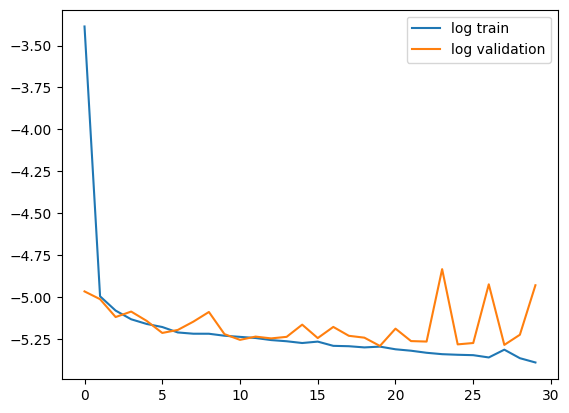

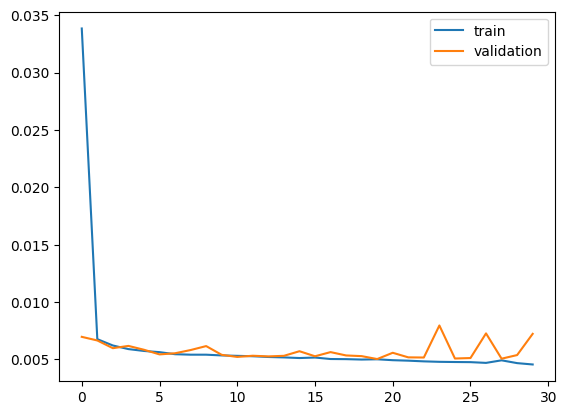

In [53]:
import math
plt.plot([math.log(tl) for tl in train_losses], label='log train')
plt.plot([math.log(tl) for tl in valid_losses], label='log validation')
plt.title("Log Loss")
plt.legend()
plt.show()

plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='validation')
plt.title("Loss")
plt.legend()
plt.show()

## Evaluation

1. Sample 36 random samples from testset (your own dataset class)
2. Give each of the 36 samples to your trained model and get the outputs
3. Visualize `input` (black-and-white image), `output` (output of the model with the given black-and-white input image) and `ground truth` (the actual RGB image)



In [54]:
testset = BlackAndWhiteCIFAR10(root='./data', train=False,
                                        download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, shuffle=True, batch_size=36)

Files already downloaded and verified


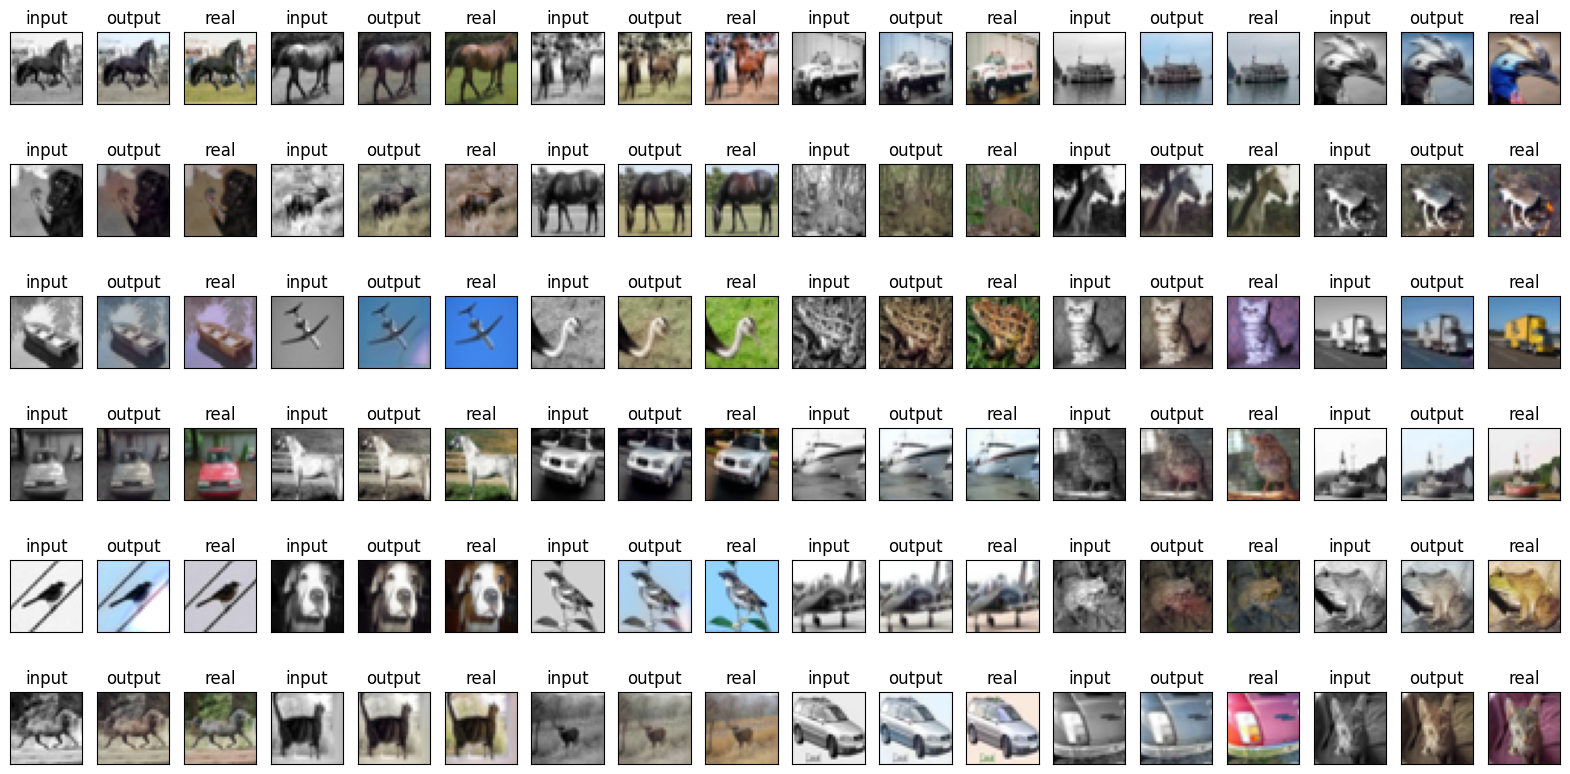

In [55]:
rows, cols = 6, 6
f, axarr = plt.subplots(rows, cols * 3, figsize=(20, 10))
import warnings
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )
pics = []
with torch.no_grad():
      for data in testloader:
          inputs, labels = data[0].to(device), data[1].to(device)
          outputs = net(inputs)
          for i, o, l in zip(inputs, outputs, labels):
            pics.append((i, o, l))

for i in range(rows):
  for j in range(cols):
    gray, colored, real = pics[i * cols + j]
    axarr[i, 3 * j + 1].imshow(colored.detach().cpu().numpy().transpose(1, 2, 0)) #, cmap='pink')
    axarr[i, 3 * j].imshow(gray.detach().cpu().numpy()[0], cmap='gray')
    axarr[i, 3 * j + 2].imshow(real.detach().cpu().numpy().transpose(1, 2, 0))
    axarr[i, 3 * j].set_title("input")
    axarr[i, 3 * j + 1].set_title("output")
    axarr[i, 3 * j + 2].set_title("real")

    axarr[i, 3 * j].get_xaxis().set_visible(False)
    axarr[i, 3 * j].get_yaxis().set_visible(False)
    axarr[i, 3 * j + 1].get_xaxis().set_visible(False)
    axarr[i, 3 * j + 1].get_yaxis().set_visible(False)
    axarr[i, 3 * j + 2].get_xaxis().set_visible(False)
    axarr[i, 3 * j + 2].get_yaxis().set_visible(False)
plt.show()